In [1]:
from noise import generate_noise_realization
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from datageneration.datageneration.waveforms import *
from datageneration.datageneration.distributions import *
from datageneration.datageneration.population_model import *
import sys
from importlib import reload
reload(sys.modules["datageneration.datageneration.waveforms"])
reload(sys.modules["datageneration.datageneration.distributions"])
reload(sys.modules["datageneration.datageneration.population_model"])
from tqdm import tqdm

/home/alexander/miniconda3/envs/lisa-pop-env-1/lib/python3.12/site-packages/numpy/_core/getlimits.py:551: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


# Generate realistic LISA noise

In [2]:
dt_noise = 4
dur_noise = int(5e5)

In [3]:
noise_dict = generate_noise_realization(dt_noise, # dt (in s)
                                        dur_noise
#                                         30*24*3600 # Tobs (in s)
                                       )

/home/alexander/miniconda3/envs/lisa-pop-env-1/lib/python3.12/site-packages/lisatools/detector.py:633: RuntimeWarning: divide by zero encountered in divide
  Sa_a = Sa_a_in * (1.0 + (0.4e-3 / frq) ** 2) * (1.0 + (frq / 8e-3) ** 4)
/home/alexander/miniconda3/envs/lisa-pop-env-1/lib/python3.12/site-packages/lisatools/detector.py:635: RuntimeWarning: divide by zero encountered in power
  Sa_d = Sa_a * (2.0 * np.pi * frq) ** (-4.0)
/home/alexander/miniconda3/envs/lisa-pop-env-1/lib/python3.12/site-packages/lisatools/detector.py:637: RuntimeWarning: invalid value encountered in multiply
  Sa_nu = Sa_d * (2.0 * np.pi * frq / C_SI) ** 2
/home/alexander/miniconda3/envs/lisa-pop-env-1/lib/python3.12/site-packages/lisatools/detector.py:642: RuntimeWarning: divide by zero encountered in divide
  Soms_d = Soms_d_in * (1.0 + (2.0e-3 / f) ** 4)
/home/alexander/miniconda3/envs/lisa-pop-env-1/lib/python3.12/site-packages/lisatools/detector.py:644: RuntimeWarning: invalid value encountered in multiply


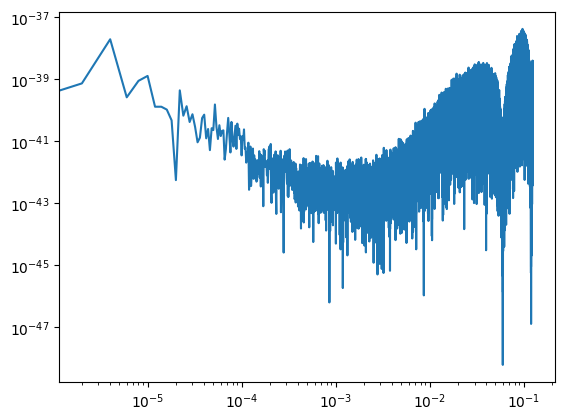

In [4]:
plt.loglog(noise_dict['freqs'],noise_dict['PSD'][0])

In [5]:
# note that noise timeseries for A,E,T channels is here:
noise_dict["timeseries"],noise_dict['ts']

(array([[-1.80904866e-21,  7.27293455e-21, -2.25520673e-21, ...,
         -1.79897635e-20, -5.10671417e-21,  1.12200705e-20],
        [-1.88873329e-20,  8.74681087e-21,  4.33297522e-22, ...,
          4.64544152e-22,  4.31628806e-21,  5.97456273e-21],
        [ 9.76719217e-21,  4.76638280e-21,  8.58632081e-22, ...,
         -1.51508837e-20,  8.34398772e-21, -1.32496228e-20]],
       shape=(3, 125000)),
 array([0.000000e+00, 4.000032e+00, 8.000064e+00, ..., 4.999920e+05,
        4.999960e+05, 5.000000e+05], shape=(125000,)))

In [6]:
def quick_mc(m1,m2):
    return (m1*m2)**(3/5)/(m1+m2)**(1/5)

In [7]:
quick_mc(0.17,0.17),quick_mc(1.3,1.3)

(0.14799359576034113, 1.1317157322849616)

# Generate the population

In [8]:
limits = {'chirp_mass':          [0.5, 1.1],  # In solar masses
#           'seperation':          [0.5, 25.0],   # In 1e8 meters
          'seperation':          [5.0, 10.0],   # In 1e8 meters
          'luminosity_distance': [1.0, 50.0],     # In kilo parsecs
          'phase':               [0, 2*np.pi]}
## Instantiate the population distribution object
N_dwd = 1500
dist = PowerLawChirpPowerLawSeperation(limits=limits, 
                                       distance_power_law_index=1,   # p(d) ~ d
                                       N_white_dwarfs=N_dwd,
                                       duration = dur_noise,
                                       sample_rate = 1/dt_noise,
                                       poisson=True) 			     # Total Number of sources should be drawn from poisson distribution

Lambda = {'alpha' : 4.0, 'beta' : -2.0}
# popdict = dist.waveform.compute_waveform_parameters(dist.generate_samples(Lambda, size=N_dwd))
poptimes, popstrains = dist.generate_time_series(Lambda,summed=False)
popdict = dist.samples_from_population
df = pd.DataFrame(popdict)
# popstrains = popstrains

In [9]:
## hacky but works for the toy model
## setting arbitrary (flat) response functions
R_LISA = 1e-3
# popstrains = np.sqrt(R_LISA)*popstrains
popstrains = R_LISA*popstrains

In [10]:
popstrains.shape

(125000, 1439)

In [11]:
dist.N_white_dwarfs

array(1439)

In [12]:
poptimes

array([0.000000e+00, 4.000032e+00, 8.000064e+00, ..., 4.999920e+05,
       4.999960e+05, 5.000000e+05], shape=(125000,))

In [13]:
df.keys()

Index(['amplitude', 'frequency', 'phase', 'chirp_mass', 'seperation',
       'luminosity_distance'],
      dtype='object')

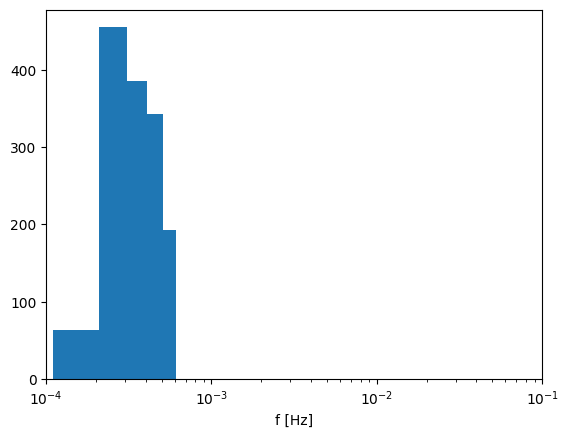

In [14]:
## look at the frequency dists
plt.figure()
plt.hist(df['frequency'],bins=np.linspace(10**-5,10**-1,1000))
plt.xscale('log')
plt.xlim(1e-4,1e-1)
plt.xlabel("f [Hz]")
plt.show()

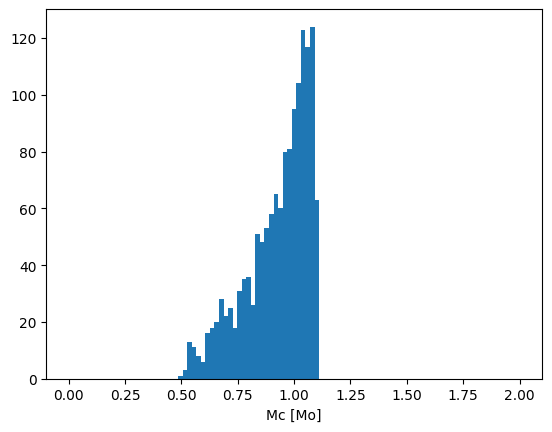

In [15]:
## look at the frequency dists
plt.figure()
plt.hist(df['chirp_mass'],bins=np.linspace(0,2,100))
# plt.xscale('log')
# plt.xlim(1e-4,1e-1)
plt.xlabel("Mc [Mo]")
plt.show()

In [16]:
# poptimes, popstrains = dist.waveform.generate_waveforms(popdict)

In [17]:
popstrains.shape

(125000, 1439)

In [18]:
# dt = poptimes[1] - poptimes[0]
dt = dt_noise

In [19]:
from utils import get_rfft
# possible bug here in frequencies when vectorized
popfreq, popstrainsfft = get_rfft(popstrains.T, poptimes, 1/dt_noise)
popfreq = np.fft.rfftfreq(len(poptimes),dt_noise)

In [20]:
popstrainsfft.shape

(1438, 62501)

In [21]:
popfreq.shape

(62501,)

In [22]:
# noise timeseries is calibrated so that scipy.signal.welch gives correct amplitude

In [23]:
fw, popwelch = scipy.signal.welch(np.sum(popstrains.T,axis=0),fs=1/dt,window='hann',noverlap=0.0,nperseg=256*8)
# fw, popwelch = scipy.signal.welch(popstrains,fs=1/dt,window='hann',noverlap=0.0,nperseg=256*8)

In [24]:
fw.shape

(1025,)

In [25]:
noise_dict['timeseries'].shape

(3, 125000)

In [26]:
poptimes[1] - poptimes[0],len(poptimes)

(np.float64(4.000032000256002), 125000)

In [27]:
noise_dict.keys()

dict_keys(['expected_PSD', 'fft', 'freqs', 'timeseries', 'ts', 'PSD'])

/home/alexander/miniconda3/envs/lisa-pop-env-1/lib/python3.12/site-packages/gwpy/plot/axes.py:82: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  return func(self, **kw)


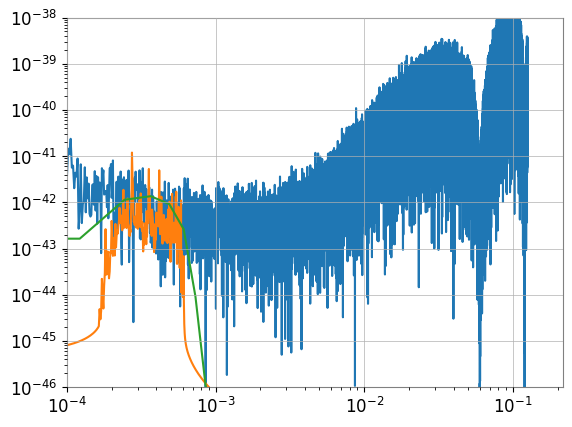

In [28]:
plt.figure()
plt.loglog(noise_dict['freqs'],noise_dict['PSD'][0])
plt.loglog(popfreq,np.sum((np.abs(popstrainsfft))**2/poptimes[-1],axis=0))
plt.loglog(fw,popwelch)
plt.xlim(1e-4,1-1)
plt.ylim(1e-46,1e-38)
plt.show()

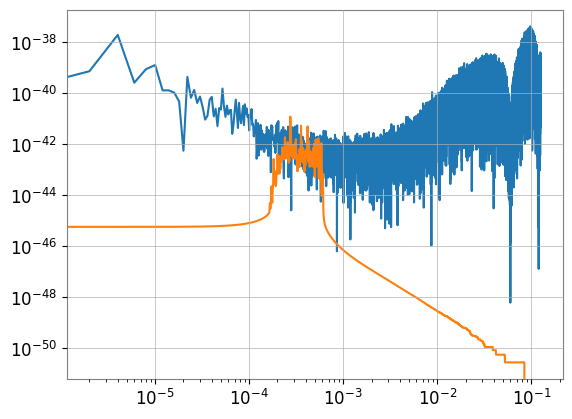

In [29]:
plt.loglog(noise_dict['freqs'],noise_dict['PSD'][0])
plt.loglog(popfreq,np.sum(np.abs(popstrainsfft)**2/poptimes[-1],axis=0))

In [30]:
## full time series
times_full = poptimes
hoft_full = np.sum(popstrains.T,axis=0) + noise_dict["timeseries"][0]
fs_full, fullwelch = scipy.signal.welch(hoft_full,fs=1/dt,window='hann',noverlap=0.0,nperseg=256*8)

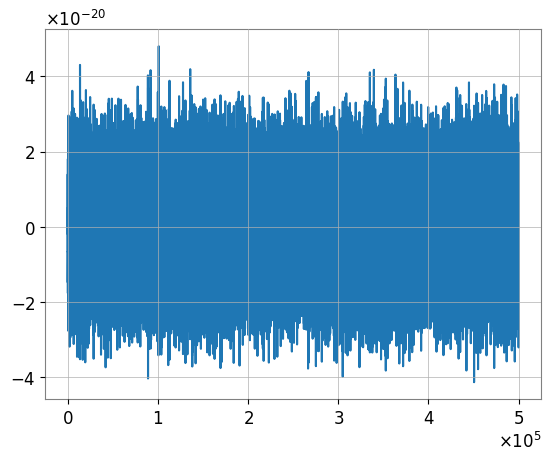

In [31]:
plt.figure()
plt.plot(times_full,hoft_full)
plt.show()

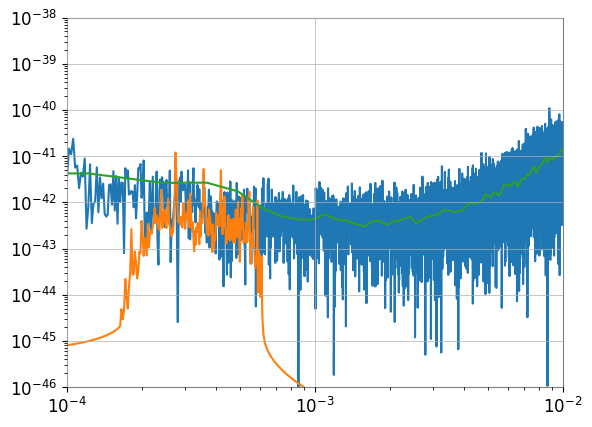

In [32]:
plt.figure()
plt.loglog(noise_dict['freqs'],noise_dict['PSD'][0])
plt.loglog(popfreq,np.sum(np.abs(popstrainsfft)**2/poptimes[-1],axis=0))
plt.loglog(fs_full,fullwelch)
plt.xlim(1e-4,1e-2)
plt.ylim(1e-46,1e-38)
plt.show()

# Iterative subtraction method

In [33]:
## make an array of fs x N_dwd
## where for each binary we have the fft of the time series without that binary
fw_atw, all_too_welch = scipy.signal.welch(hoft_full - popstrains.T,fs=1/dt,window='hann',noverlap=0.0,nperseg=256*8)
# fw, popwelch = scipy.signal.welch(popstrains,fs=1/dt,window='hann',noverlap=0.0,nperseg=256*8)
all_too_welch.shape

(1439, 1025)

In [34]:
fw_atw

array([0.00000000e+00, 1.22070312e-04, 2.44140625e-04, ...,
       1.24755859e-01, 1.24877930e-01, 1.25000000e-01],
      shape=(1025,))

In [35]:
## bin the binaries by frequency
sorted_f_idx = np.digitize(np.array(df['frequency']),fs_full)

In [36]:
sorted_f_idx

array([3, 5, 2, ..., 3, 4, 4], shape=(1439,))

In [37]:
left_one_out = np.array([all_too_welch[ii,fidx] for ii,fidx in enumerate(sorted_f_idx)])

In [38]:
left_one_out.shape

(1439,)

In [39]:
left_one_out

array([2.66801443e-42, 7.79281977e-43, 2.64278431e-42, ...,
       2.65471584e-42, 1.73759478e-42, 1.73414317e-42],
      shape=(1439,))

In [40]:
## snrs for circular, monochromatic binaries
snrs = np.sqrt(dur_noise*R_LISA*np.array(df['amplitude'])**2 / (4*left_one_out))

In [41]:
np.max(dur_noise*R_LISA*np.array(df['amplitude'])**2)

np.float64(5.412947557453278e-38)

In [42]:
snrs.shape

(1439,)

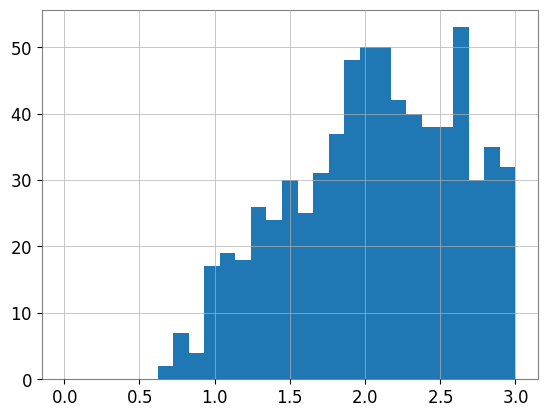

In [43]:
plotmax = 10
plt.figure()
plt.hist(snrs,bins=np.linspace(0,plotmax,10*plotmax))
plt.show()

In [44]:
first_iter_res = snrs > 7
N_res = np.sum(first_iter_res)
print(N_res)

161


In [45]:
popstrains.shape

(125000, 1439)

In [46]:
fs_full[1] - fs_full[0],fs_full[-1] - fs_full[-2]

(np.float64(0.0001220703125), np.float64(0.0001220703125))

In [47]:
# need to implement this, basically:
# add noise timeseries + WDs
# compute welched PSD, subtract WDs that exceed SNR (to current noise+signals PSD of your threshold (typically 7))
# repeat above step at least 15-ish times

## bin the binaries by frequency
## such that the center of each bin is one of our fft frequencies
delf = fs_full[1] - fs_full[0]
sorted_f_idx = np.digitize(np.array(df['frequency']),fs_full+0.5*delf)

current_hoft_full = hoft_full
current_unres_idx = np.arange(popstrains.shape[1],dtype=int)
current_res_idx = np.array([],dtype=int)
prev_N = 0
# current_unresolved_filt = np.ones(popstrains.shape[1],dtype=bool)

for i in range(5):
    ## make an array of fs x N_dwd
    ## where for each binary we have the fft of the time series without that binary
    ## only including systems we haven't yet resolved
    fs_i, current_welch_loo = scipy.signal.welch(current_hoft_full - popstrains[:,current_unres_idx].T,
                                               fs=1/dt,window='hann',noverlap=0.0,nperseg=256*8)
    current_latf = np.array([current_welch_loo[ii,fidx] for ii,fidx in enumerate(sorted_f_idx[current_unres_idx])])
    ## snrs for circular, monochromatic binaries
    current_snrs = np.sqrt(dur_noise*R_LISA*np.array(df['amplitude'])[current_unres_idx]**2 / (4*current_latf))
    
    ## update
    current_resolved_filt = current_snrs >= 7
    current_res_idx = np.append(current_res_idx,current_unres_idx[current_resolved_filt])
    current_N = len(current_res_idx)
    print("N resolved: {}".format(current_N))
    current_unres_idx = current_unres_idx[np.invert(current_resolved_filt)]
    current_hoft_full = current_hoft_full - np.sum(popstrains[:,current_res_idx],axis=1)
    if current_N == prev_N:
        print("Iterative subtraction has converged, stopping after {} iterations.".format(i))
        break
    else:
        prev_N = current_N
    
    

    

N resolved: 130
N resolved: 227
N resolved: 227
Iterative subtraction has converged, stopping after 2 iterations.


In [48]:
current_snrs

array([3.33469876, 2.40168331, 2.72881384, ..., 5.69951439,
       3.3367703 , 3.70713326], shape=(1212,))

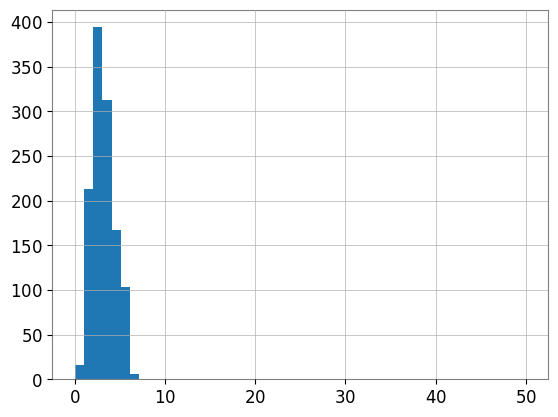

In [49]:
plotmax = 50
plt.figure()
plt.hist(current_snrs,bins=np.linspace(0,plotmax,plotmax))
plt.show()

In [50]:
frac_res = len(current_res_idx)/popstrains.shape[1]
frac_res

0.15774843641417652

In [51]:
## get a welched noise PSD
noft_A = noise_dict["timeseries"][0,:]
dtn = noise_dict['ts'][1] - noise_dict['ts'][0]

fs_test, noise_psd_test = scipy.signal.welch(noft_A,fs=1/dtn,window='hann',noverlap=0.0,nperseg=256*8)

In [52]:
## get info for plotting the resolved and unresolvd binaries
fw_unresolved, welch_unresolved = scipy.signal.welch(np.sum(popstrains[:,current_unres_idx],axis=1),
                                               fs=1/dt,window='hann',noverlap=0.0,nperseg=256*8)

In [53]:
fs_resolved = np.array(df['frequency'][current_res_idx])
psds_resolved1 = 0.5*R_LISA*(fw_unresolved[1]-fw_unresolved[0])**-1 *np.array(df['amplitude'][current_res_idx])**2
# psds_resolved1 = R_LISA*np.array(df['amplitude'][current_res_idx])**2
psds_resolved = np.sum(np.abs(popstrainsfft[current_res_idx])**2/poptimes[-1],axis=0)#*(popfreq[1]-popfreq[0])

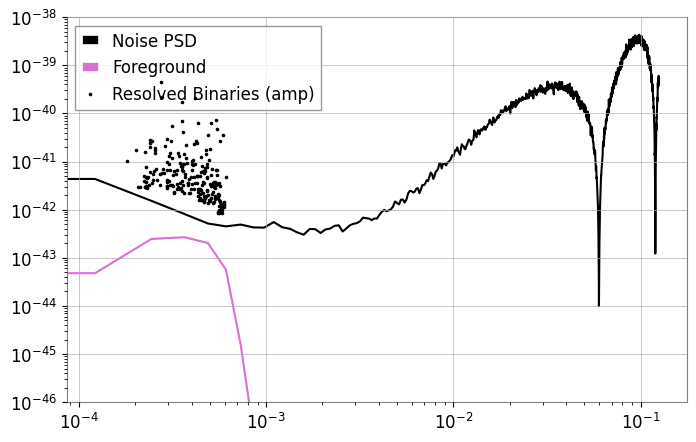

In [54]:
plt.figure(figsize=(8,5))
# plt.loglog(noise_dict['freqs'],noise_dict['PSD'][0],c='slategrey',label='Noise PSD')
plt.loglog(fs_test, noise_psd_test,c='k',label='Noise PSD')
plt.loglog(fw_unresolved,welch_unresolved,c='orchid',label='Foreground')
# plt.loglog(popfreq,psds_resolved,c='maroon',label='Resolved Binaries (fft)')
plt.scatter(fs_resolved,psds_resolved1,marker='.',s=10,c='k',label='Resolved Binaries (amp)',zorder=10)
# plt.scatter(fs_resolved,psds_resolved,marker='*',s=10,c='maroon',label='Resolved Binaries (fft)')
plt.ylim(1e-46,1e-38)
plt.legend(loc='upper left')
plt.show()

In [55]:
plt.figure()
plt.plot(np.log10(psds_resolved1/psds_resolved))
plt.show()
print(np.sum((psds_resolved - psds_resolved1)>0.1*psds_resolved1))

ValueError: operands could not be broadcast together with shapes (227,) (62501,) 

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure()
plt.loglog(noise_dict['freqs'],noise_dict['PSD'][0],c='slategrey',label='Noise PSD')
plt.loglog(fw_unresolved,welch_unresolved,c='orchid',label='Foreground')
plt.scatter(fs_resolved,psds_resolved1,marker='*',s=10,c='k',label='Resolved Binaries')
# plt.ylim(1e-44,1e-35)
plt.legend()
plt.show()

# New method -- does it give the same answer?

In [ ]:
# see notes / code in foreground.py
# try it with same population and make sure the answer is identical / equivalent to iterative subtraction

This is maybe simpler than I was expecting, b/c for the fiducial population, all $w_{ij} = 1$. So all we need to do is:
 - sort by frequency bin
 - therein, sort by naive (i.e., noise-only) SNR
 - for all binaries, compute the SNR from noise + sum of all lower-amplitude binaries in that bin (with, e.g., np.cumsum)
 - $f_{res}$ will then be $\sum_i\sum_{j\ge k_i}(1) = \sum_i (N_i - k_i)$, where $N_i$ is the number of binaries in bin $i$
 - and the foregound amplitude will be the sum of the strain PSDs of all binaries in bin $i$ with $j\le k_i$

In [ ]:
## from foreground.py
def calc_Nij(A, noisePSD, wts, duration):
    '''
    Make the per-frequency SNR vector (dim 1xN_dwd)
    
    Arguments
    ------------
    A (float array)      : Sorted (ascending) DWD amplitudes
    noisePSD (float)     : Level of the noise PSD in the relevant frequency bin (i.e., S_n(f))
    wts (float or array) : weights from fiducial population (1 for now)
    '''
#     np.sqrt(dur_noise*np.array(df['amplitude'])[current_unres_idx]**2 / (4*current_latf))
    return np.sqrt(duration*A**2/(4*(noisePSD+np.cumsum(wts*A**2))))
#     return A / (noisePSD + np.cumsum(wts*A))

In [ ]:
def bin_sort_threshold(binaries,fs_full,noisePSD,duration,LISA_rx,wts=1,snr_thresh=7):
    '''
    Function to bin by frequency, then for the vector of binaries in each frequency bin, sort them by amplitude.
    
    Arguments
    -----------
    binaries (dataframe) : df with binary info. Will rephrase arguments in terms of the specific needed components later.
    fs_full (float array) : data frequencies
    noisePSD  (float)     : Level of the noise PSD in the relevant frequency bin (i.e., S_n(f))
    LISA_rx (float or array) : (pseudo) LISA response function (currently just a numerical factor)
    wts (float or array) : weights from fiducial population (1 for now)
    snr_thresh (float)    : the SNR threshold to condition resolved vs. unresolved on
    '''
    dwd_fs = np.array(binaries['frequency'])
    dwd_amps = np.array(binaries['amplitude'])
    dwd_idx = np.arange(len(binaries['amplitude']))
    ## bin the binaries by frequency
    ## first, find which frequency bin each binary is in
    delf = fs_full[1] - fs_full[0]
    f_idx = np.digitize(dwd_fs,fs_full+0.5*delf)
    ## now created a ragged list of arrays of varying sizes, corresponding to N_dwd(f_i)
    ## each entry is an array containing the indices of the DWDs in that bin, sorted by ascending amplitude*
    ##     * under the current assumption of uniform responses, this is equivalent to sorting by the naive SNR
    ##       (!! -- we will need to refine this in future)
    
    fbin_res_list = []
    foreground_amp = np.zeros(len(fs_full))
    
    for i in range(np.max(f_idx)+1):
        fbin_mask_i = np.array(f_idx == i)
        fbin_amps_i = dwd_amps[fbin_mask_i]*np.sqrt(LISA_rx) ## sqrt because we square the amplitudes to get Sgw
        fbin_sort_i = np.argsort(fbin_amps_i)
        re_sort_i = np.argsort(fbin_sort_i) ## this will allow us to later return to the original order
        
        fbin_Nij = calc_Nij(fbin_amps_i[fbin_sort_i],noisePSD[i],wts,duration)
        res_mask_i = fbin_Nij>=snr_thresh
        res_mask_i_resort = res_mask_i[re_sort_i]
        fbin_res_list.append(dwd_idx[fbin_mask_i][res_mask_i_resort])
        
        foreground_amp[i] = np.sum(0.5*fbin_amps_i[np.invert(res_mask_i_resort)]**2)

    N_res = np.sum([len(rli) for rli in fbin_res_list])
    
    return foreground_amp, N_res, fbin_res_list
        
        
        

In [ ]:
noise_dict["timeseries"].shape

In [ ]:
test_fg, test_N, test_res_list = bin_sort_threshold(df,fs_test,noise_psd_test,dur_noise,R_LISA,wts=1,snr_thresh=7)

In [ ]:
# test_res_list

In [ ]:
test_N

In [ ]:
## make a welched foreground to check amplitudes

In [ ]:
for i, arr in enumerate(test_res_list):
    if i==0:
        tarr = arr
    else:
        tarr = np.append(tarr,arr)

In [ ]:
tarr

In [ ]:
popstrains.shape

In [ ]:
## get info for plotting the resolved and unresolvd binaries
unres_tarr = np.arange(popstrains.shape[1])
unres_tarr = unres_tarr[[(False if i in tarr else True) for i in unres_tarr ]]
fw_unresolved_new, welch_unresolved_new = scipy.signal.welch(np.sum(popstrains[:,unres_tarr],axis=1),
                                               fs=1/dt,window='hann',noverlap=0.0,nperseg=256*8)

In [ ]:
plt.figure()
plt.loglog(fs_test,noise_psd_test)
plt.loglog(fs_test,test_fg)
plt.loglog(fw_unresolved_new,welch_unresolved_new)
plt.show()

In [ ]:
fs_resolved = np.array(df['frequency'][current_res_idx])
psds_resolved1 = 0.5*R_LISA*(fw_unresolved[1]-fw_unresolved[0])**-1 *np.array(df['amplitude'][current_res_idx])**2

fs_resolved_fast = np.array(df['frequency'][tarr])
psds_resolved_fast = 0.5*R_LISA*(fw_unresolved_new[1]-fw_unresolved_new[0])**-1 *np.array(df['amplitude'][tarr])**2

In [ ]:
current_res_idx

In [ ]:
welch_unresolved_new

In [ ]:
plt.figure(figsize=(8,5))
# plt.loglog(noise_dict['freqs'],noise_dict['PSD'][0],c='slategrey',label='Noise PSD')
plt.loglog(fs_test, noise_psd_test,c='k',label='Noise PSD')
plt.loglog(fw_unresolved,welch_unresolved,c='orchid',label='Foreground (iterative)')
plt.loglog(fw_unresolved_new,welch_unresolved_new,c='maroon',label='Foreground (fast)',ls='--')
# plt.loglog(popfreq,psds_resolved,c='maroon',label='Resolved Binaries (fft)')
plt.scatter(fs_resolved,psds_resolved1,marker='.',s=10,c='orchid',label='Resolved Binaries (iterative)',zorder=10)
plt.scatter(fs_resolved_fast,psds_resolved_fast,marker='.',s=10,c='maroon',label='Resolved Binaries (fast)',zorder=10)
# plt.scatter(fs_resolved,psds_resolved,marker='*',s=10,c='maroon',label='Resolved Binaries (fft)')
plt.ylim(1e-46,1e-38)
plt.xlim(1e-4,1e-2)
plt.legend()#loc='lower right')
# for ext in ['.png,.pdf']:
#     plt.savefig('N1505_fast_v_iter'+ext)
plt.show()

In [ ]:
plt.figure()
plt.loglog(noise_dict['freqs'],noise_dict['PSD'][0],c='slategrey',label='Noise PSD')
plt.loglog(fw_unresolved,welch_unresolved,c='orchid',label='Foreground (iterative)')
plt.loglog(fs_test,test_fg,c='navy',label='Foreground (fast)')
# plt.loglog(popfreq,psds_resolved,c='maroon',label='Resolved Binaries (fft)')
plt.scatter(fs_resolved,psds_resolved1,marker='.',s=10,c='k',label='Resolved Binaries (iterative)',zorder=10)
# plt.scatter(fs_resolved,psds_resolved,marker='*',s=10,c='maroon',label='Resolved Binaries (fft)')
plt.ylim(1e-46,1e-38)
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(8,5))
# plt.loglog(noise_dict['freqs'],noise_dict['PSD'][0],c='slategrey',label='Noise PSD')
plt.loglog(fs_test, noise_psd_test,c='k',label='Noise PSD')
plt.loglog(fw_unresolved,welch_unresolved,c='orchid',label='Foreground')
# plt.loglog(popfreq,psds_resolved,c='maroon',label='Resolved Binaries (fft)')
plt.scatter(fs_resolved,psds_resolved1,marker='.',s=10,c='k',label='Resolved Binaries (amp)',zorder=10)
# plt.scatter(fs_resolved,psds_resolved,marker='*',s=10,c='maroon',label='Resolved Binaries (fft)')
plt.ylim(1e-46,1e-38)
plt.legend(loc='upper left')
plt.show()

In [ ]:
test_res_list

In [ ]:
tarr

In [ ]:
df['frequency'][tarr]

In [ ]:
tf_arr = np.zeros(len(tarr))
n_arr = np.zeros(len(tarr))
for i, idx in enumerate(tarr):
    f_idx = np.argmin(np.abs(fs_test - df['frequency'][idx]))
    tf_arr[i] = fs_full[f_idx]

In [ ]:
plotmax = 50
snrs_fast = np.sqrt(noise_dur*np.array(df['amplitude'])[tarr]**2/(4*(noisePSD)))
plt.figure()
plt.hist(current_snrs,bins=np.linspace(0,plotmax,plotmax),label='iterative',alpha=0.5)
plt.hist(current_snrs,bins=np.linspace(0,plotmax,plotmax),label='iterative',alpha=0.5)
plt.show()